In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")

# read consensus, not noise, switches
switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1)
switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv") %>%
    filter(NotNoise==1 & IsModel==1)

# read mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique

wgs <- read_tsv("../data/mutations/wgs_mutations.txt") %>%
    select(Tumor,Gene,Symbol,Patient) %>%
    unique

# Read IntoGene mutational drivers
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>% 
    select(geneHGNCsymbol) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Some stats about switches

In [2]:
# num switches
nrow(switches)

# num genes
switches %>% select(GeneId,Symbol) %>% unique %>% nrow

[1] 10360

[1] 7946

In [3]:
# Numbers
cdsNormal <- as.logical(switches$CDS_Normal)
cdsTumor <- as.logical(switches$CDS_Tumor)
functional <- as.logical(switches$IsFunctional)

# any functional
sum(functional)

[1] 8035

In [4]:
# two protein coding isoforms
sum(cdsNormal & cdsTumor)
# percentage
sum(cdsNormal & cdsTumor)/nrow(switches) * 100

[1] 8869

[1] 85.60811

In [5]:
# only normal isoform
sum(cdsNormal & !cdsTumor)
# percentage
sum(cdsNormal & !cdsTumor)/nrow(switches) * 100

[1] 967

[1] 9.333977

In [6]:
# only tumor isoform
sum(!cdsNormal & cdsTumor)
# percentage
sum(!cdsNormal & cdsTumor)/nrow(switches) * 100

[1] 277

[1] 2.673745

In [7]:
# two protein coding isoforms & functional
sum(cdsNormal & cdsTumor & functional)
# percentage
sum(cdsNormal & cdsTumor & functional)/sum(cdsNormal & cdsTumor) * 100

[1] 6797

[1] 76.63773

In [8]:
# unbalance between only niso and only tiso
x <- sum(cdsNormal & !cdsTumor)
n <- sum(!cdsNormal & cdsTumor)+sum(cdsNormal & !cdsTumor)
binom.test(x,n,0.5)


	Exact binomial test

data:  x and n
number of successes = 967, number of trials = 1244, p-value < 2.2e-16
alternative hypothesis: true probability of success is not equal to 0.5
95 percent confidence interval:
 0.7531690 0.8001749
sample estimates:
probability of success 
             0.7773312 


## Stats about patient recurrence

### Differences between functional and non-functional


	Wilcoxon rank sum test with continuity correction

data:  switches$PatientNumber[switches$IsFunctional == 1] and switches$PatientNumber[switches$IsFunctional == 0]
W = 9668400, p-value = 0.009835
alternative hypothesis: true location shift is not equal to 0


[1] 1.094298

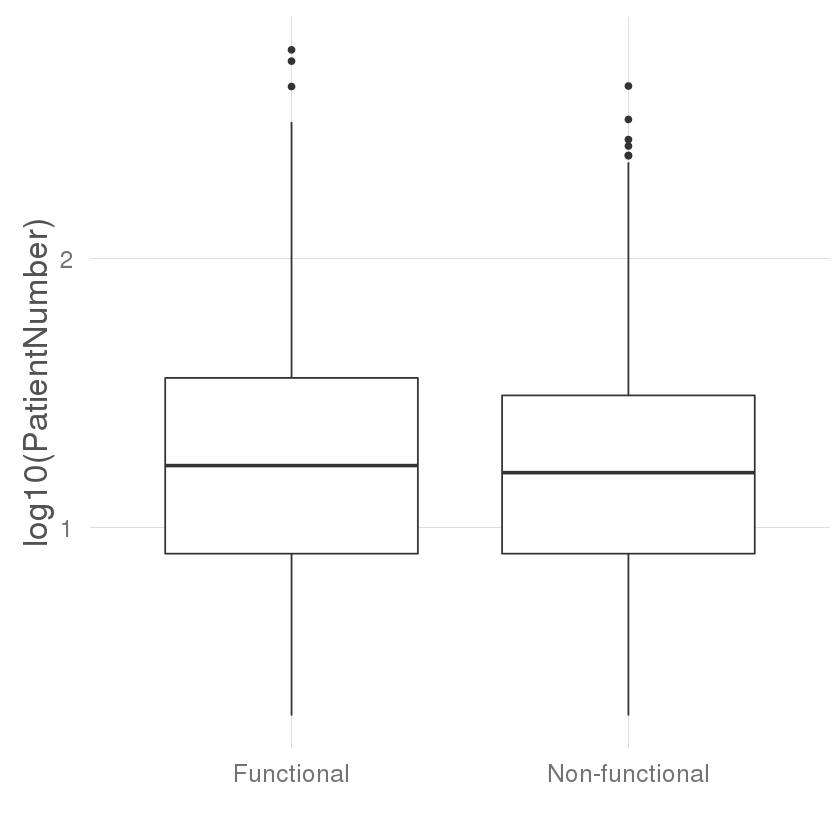

In [9]:
ggplot(switches,aes(y=log10(PatientNumber),x=revalue(as.character(IsFunctional),c("1"="Functional","0"="Non-functional")))) +
    geom_boxplot() + 
    smartas_theme() +
    labs(x="")

wilcox.test(switches$PatientNumber[switches$IsFunctional==1],switches$PatientNumber[switches$IsFunctional==0])
mean(switches$PatientNumber[switches$IsFunctional==1])/mean(switches$PatientNumber[switches$IsFunctional==0])

### Comparison to mutation data
We will use mutation data to put switch data into context.

#### Number of alterations per patient

In [10]:
# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=length(Patient))

## WGS mutation
genesMutated.perPatient <- wgs %>%
    group_by(Tumor,Patient) %>%
    summarise(WGS=length(Patient))

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
lines <- "Tumor\tSplicedGenes\tGenes\nbrca\t12383\t20530\nprad\t11849\t20530\nthca\t11812\t20530\ncoad\t11498\t20530\nhnsc\t11583\t20530\nkich\t11607\t20530\nkirc\t12205\t20530\nkirp\t11853\t20530\nlihc\t10490\t20530\nluad\t12046\t20530\nlusc\t12070\t20530\n"
consideredGenes <- read_tsv(lines) %>%
    set_colnames(c("Tumor","SplicedGenes","Genes"))

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(genesMutated.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, WGS=WGS/Genes,
           Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

Using Tumor, Patient as id variables
Warning message:
: Removed 4531 rows containing non-finite values (stat_boxplot).

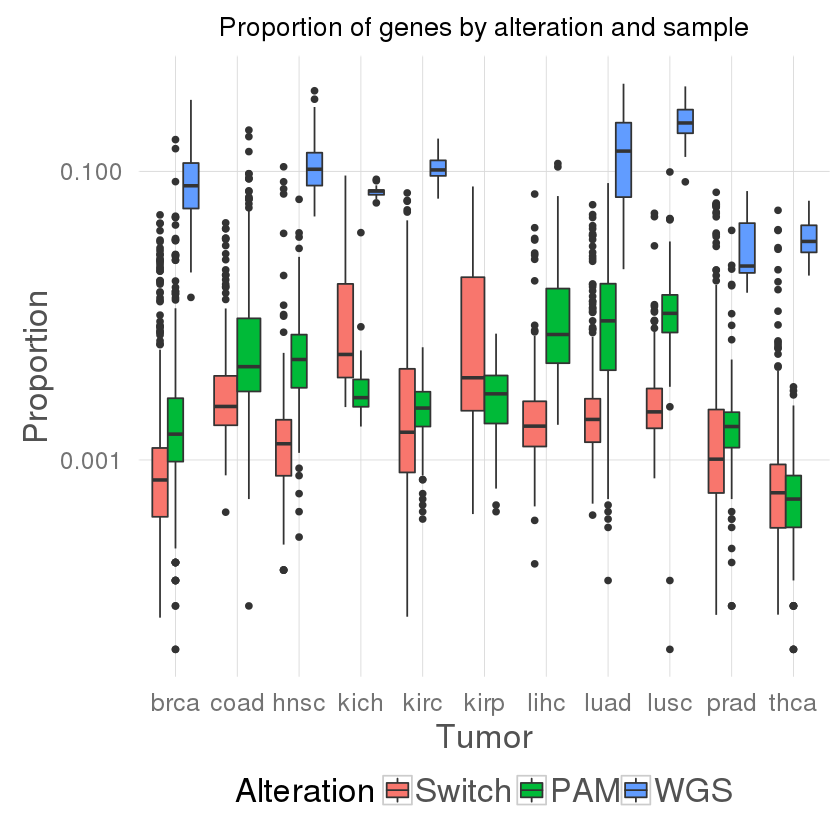

In [11]:
# show distribution of genes affected through each mechanism per patient
recurrence %>%
    melt %>%
    set_colnames(c("Tumor","Patient","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
        geom_boxplot() + 
        smartas_theme() +
        scale_y_log10() +
        theme(legend.position="bottom", plot.title = element_text(size=16)) +
        labs(title="Proportion of genes by alteration and sample")

Warning message:
: Removed 470 rows containing missing values (geom_point).

[1] -0.00376669

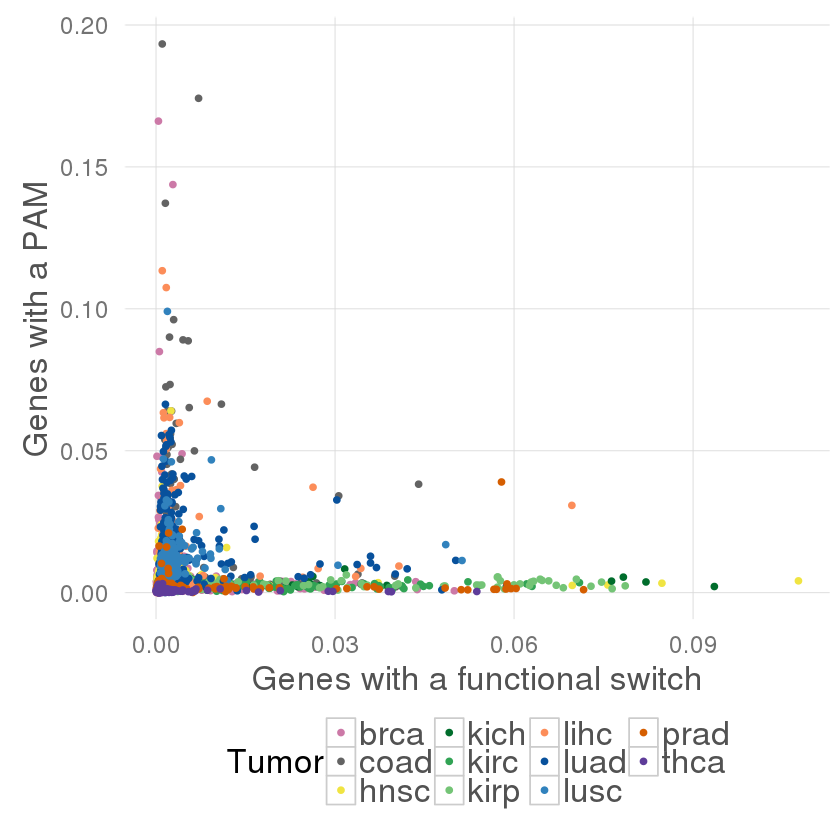

In [12]:
# show lack of correlation between mutations and switches
recurrence %>%
    ggplot(aes(x=Switch,y=PAM)) + 
    geom_point(aes(color=Tumor)) + 
    smartas_theme() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM")

cor(recurrence$PAM, recurrence$Switch, use="complete.obs")

Warning message:
: Removed 470 rows containing non-finite values (stat_smooth).Warning message:
: Removed 470 rows containing missing values (geom_point).

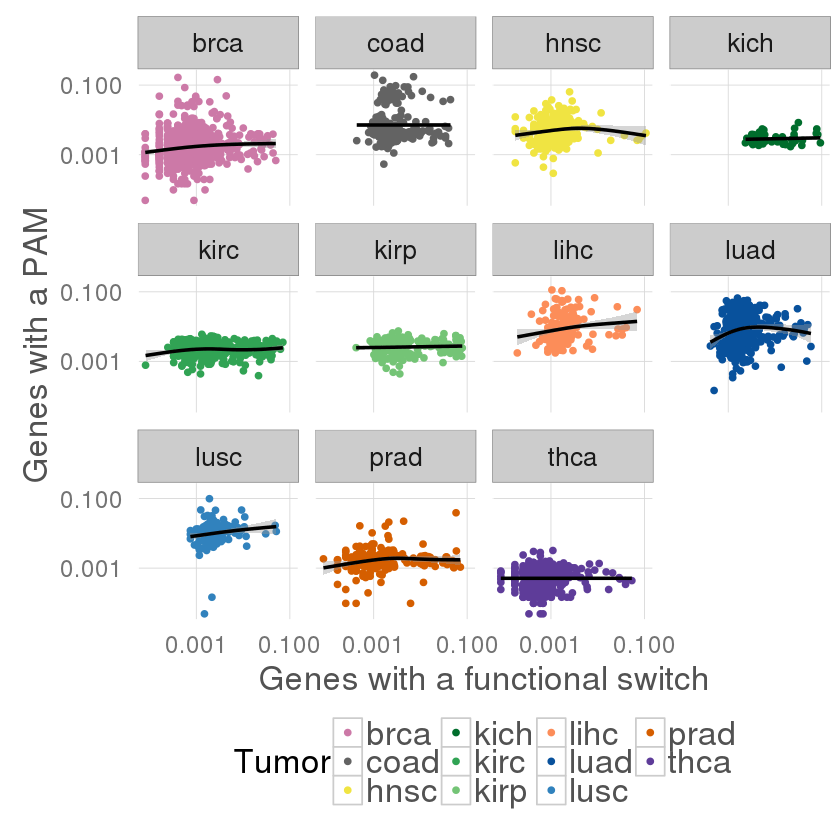

In [13]:
recurrence %>%
    ggplot(aes(x=Switch,y=PAM,color=Tumor)) + 
    geom_point() + 
    geom_smooth(color="black") +
    smartas_theme() +
    scale_y_log10() +
    scale_x_log10() +
    scale_color_manual(values=colorPalette) + 
    theme(legend.position="bottom") +
    labs(x="Genes with a functional switch", y="Genes with a PAM") + 
    facet_wrap(~ Tumor)

#### Number of altered samples per gene

In [14]:
# count number of genes altered per patient
## WES mutation
samplesPAM.perGene <- wes %>%
    group_by(Tumor,Gene) %>%
    summarise(PAM=length(Gene))

## WGS mutation
samplesMutated.perGene <- wgs %>%
    group_by(Tumor,Gene) %>%
    summarise(WGS=length(Gene))

## a functional switch
samplesSwitched.perGene <- switches.split$Patients_affected[switches.split$IsFunctional==1] %>%
    strsplit(",") %>%
    set_names(switches.split$Gene[switches.split$IsFunctional==1]) %>%
    lapply(length) %>%
    do.call("rbind",.) %>%
    as.data.frame %>%
    set_colnames("Samples") %>%
    mutate(., Gene=rownames(.),Tumor=switches.split$Tumor[switches.split$IsFunctional==1]) %>%
    group_by(Tumor,Gene) %>%
    summarise(Switch=sum(Samples))

# use number of patients per tumor to normalize the observations
wesPatients <-  wes %>%
    select(Tumor,Patient) %>%
    unique %>%
    group_by(Tumor) %>%
    summarise(WESPatients=length(Patient))

wgsPatients <-  wgs %>%
    select(Tumor,Patient) %>%
    unique %>%
    group_by(Tumor) %>%
    summarise(WGSPatients=length(Patient))

splicingPatients <- do.call("rbind",nPatients) %>%
    as.data.frame %>%
    set_colnames("SplicingPatients") %>%
    mutate(.,Tumor=rownames(.)) %>%
    filter(Tumor!="total")

patients <- merge(wesPatients,wgsPatients,all=T) %>%
    merge(splicingPatients,all=T)

geneIncidence <- merge(samplesSwitched.perGene,samplesPAM.perGene,all=T) %>%
    merge(samplesMutated.perGene,all=T) %>%
    merge(patients) %>%
    mutate(PAM=PAM/WESPatients, WGS=WGS/WGSPatients,
           Switch=Switch/SplicingPatients) %>%
    select(everything(),-contains("Patients"))

Using Tumor, Gene as id variables
Warning message:
: Removed 248236 rows containing non-finite values (stat_boxplot).

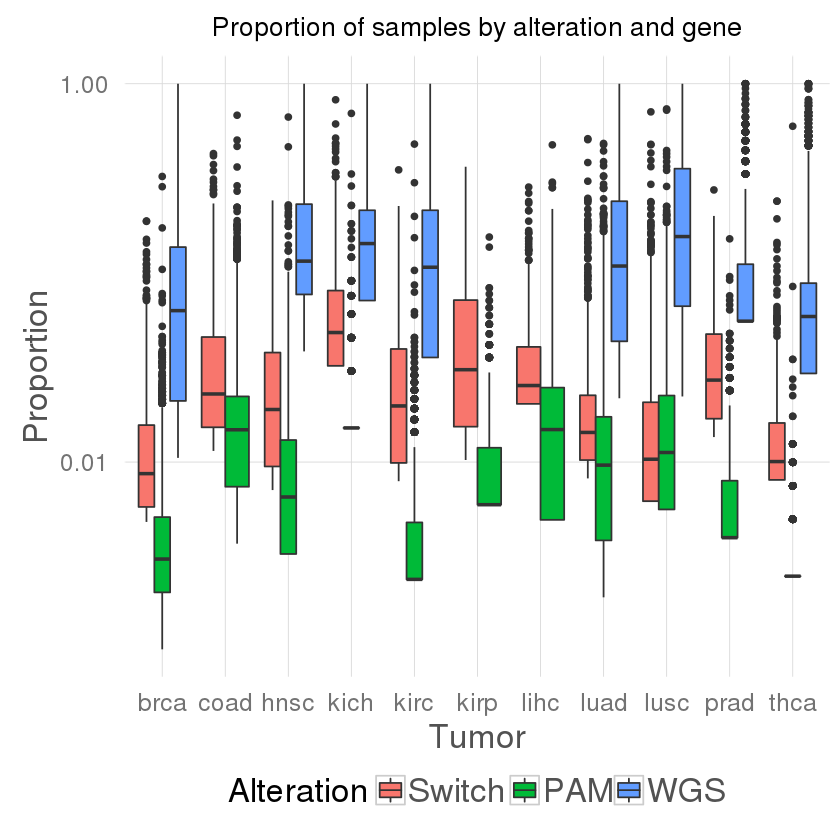

In [15]:
# show distribution of samples affected through each mechanism per gene
geneIncidence %>%
    melt %>%
    set_colnames(c("Tumor","Gene","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
    geom_boxplot() + 
    smartas_theme() +
    scale_y_log10() +
    theme(legend.position="bottom", plot.title = element_text(size=16)) +
    labs(title="Proportion of samples by alteration and gene",y="Proportion")

#### Pancancer comparison

Warning message:
: Removed 1703 rows containing non-finite values (stat_ydensity).

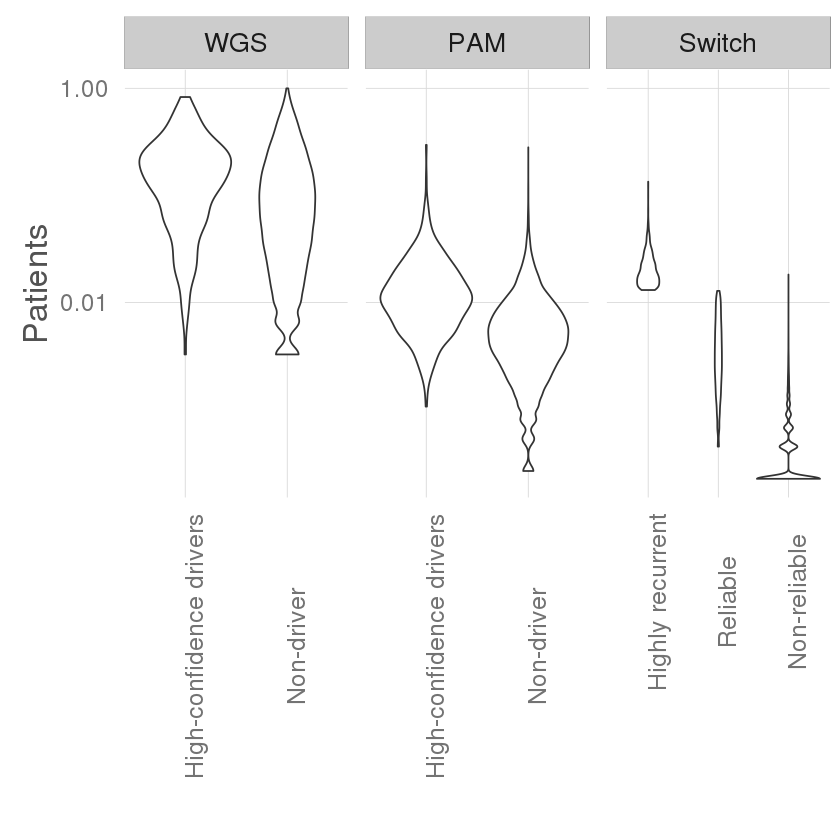

In [16]:
# Calculate number of patients
wesPatients <-  wes$Patient %>%
    unique %>%
    length

wgsPatients <-  wgs$Patient %>%
    unique %>%
    length

splicingPatients <- nPatients$total

# Annotate switches
s <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(IsFunctional == 1) %>%
    mutate(Recurrent = revalue(as.character(Recurrence),c("1"="Recurrent","0"="Non-recurrent")),
           Type = revalue(as.character(Reliable==1),c("TRUE"="Reliable","FALSE"="Non-reliable")),
           Alteration = "Switch",
           PatientNumber = PatientNumber/splicingPatients) %>%
    arrange(Type,desc(PatientNumber)) %>%
    mutate(.,Order=1:nrow(.), Type=factor(Type,levels=c("Reliable","Non-reliable")))

s$Annotation <- "Non-reliable"
s$Annotation[s$Recurrent=="Recurrent" & s$Type=="Reliable"] <- "Highly recurrent"
s$Annotation[s$Recurrent=="Non-recurrent" & s$Type=="Reliable"] <- "Reliable"

s <- s %>%
    select(Alteration,Annotation,PatientNumber)

# count number of genes altered per patient
## WES mutation
samplesPAM.perGene <- wes %>%
    group_by(Tumor,Gene,Symbol) %>%
    summarise(PAM=length(Gene))

## WGS mutation
samplesMutated.perGene <- wgs %>%
    group_by(Tumor,Gene,Symbol) %>%
    summarise(WGS=length(Gene))

m <- merge(samplesMutated.perGene,samplesPAM.perGene,all=T) %>% 
    group_by(Gene,Symbol) %>%
    summarise(WGS=sum(WGS,na.rm=T)/wgsPatients, 
              PAM=sum(PAM,na.rm=T)/wesPatients) %>%
    as.data.frame %>%
    select(Symbol,WGS,PAM) %>%
    melt(id.vars=c("Symbol")) %>%
    set_colnames(c("Symbol","Alteration","PatientNumber"))

m$Annotation <- "Non-driver"
m$Annotation[m$Symbol %in% drivers$geneHGNCsymbol] <- "High-confidence drivers"

m <- m %>%
    select(Alteration,Annotation,PatientNumber)

df <- rbind(m,s) %>%
    mutate(PatientNumber=as.numeric(PatientNumber))

df$Annotation <- factor(df$Annotation,levels=c("Highly recurrent","Reliable","Non-reliable",
                                               "High-confidence drivers","Non-driver"))

ggplot(df) +
    geom_violin(aes(x=Annotation,y=PatientNumber)) +
    smartas_theme() + 
    theme(legend.position="bottom", axis.text.x=element_text(angle=90)) +
    labs(y="Patients",x="") +
    scale_y_log10() +
    facet_grid(.~Alteration,scales="free_x")

## Stats about co-ocurrence

In [17]:
# number of functional switches with co-occurrence
sum(switches$p.mut.o[switches$IsFunctional==1] < 0.05, na.rm=T)

# number of switches with co-occurrence
sum(switches$p.mut.o < 0.05, na.rm=T)
sum(switches$p.mut.o < 0.05, na.rm=T)/nrow(switches)*100

[1] 24

[1] 29

[1] 0.2799228